In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import os
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import tensorflow as tf
import math
from sklearn.datasets import make_blobs # split a dataset into train and test sets

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
low_fi_folder="/content/drive/MyDrive/ECE496 Capstone Project/Data Augmentation/Data/lofi_maps"
hi_fi_folder="/content/drive/MyDrive/ECE496 Capstone Project/Data Augmentation/Data/hifi_maps"

num_files=len([name for name in os.listdir(low_fi_folder) if os.path.isfile(os.path.join(low_fi_folder, name))])
data_list_low_fi=[]
data_list_high_fi=[]
general_to_name_low={}
general_to_name_high={}

In [4]:
for filename in os.listdir(low_fi_folder):
    general_to_name_low[filename[5:]]=filename

for filename in os.listdir(hi_fi_folder):
    general_to_name_high[filename[5:]]=filename

In [5]:
def get_transmitter(filename):
    filename = filename.split('.')[0]
    trans = filename.split('_')[1:]

    for i in range(3):
        trans[i] = trans[i].replace('x','')
        trans[i] = trans[i].replace('y','')
        trans[i] = trans[i].replace('z','')
        trans[i] = trans[i].replace('n','-')
        trans[i] = trans[i].replace('p','.')
        trans[i] = float(trans[i])

    return trans

In [6]:
def rec_trans_p2p(rec,trans):
    return round(math.sqrt( ((rec[0]-trans[0])**2) + ((rec[1]-trans[1])**2) + ((rec[2]-trans[2])**2) ),2)

In [7]:
def addEnvData(map, trans_loc):
    dist = []
    friis = []
    LoS = []

    for i in range(len(map)):
        rec_loc = [map[i,0].item(),map[i,1].item(),map[i,2].item()]
        dist.append(rec_trans_p2p(rec_loc,trans_loc))
        friis_val = friisFormula(rec_loc,trans_loc)
        friis.append(friis_val)

        if abs(friis_val-map[i,3].item()) < 5:
            LoS.append(1)
        else:
            LoS.append(0)
    
    dist = np.array(dist)[np.newaxis].T
    friis = np.array(friis)[np.newaxis].T
    LoS = np.array(LoS)[np.newaxis].T

    return np.concatenate((map,dist,friis,LoS),axis=1)

In [8]:
def friisFormula(rec,trans):
    R = rec_trans_p2p(rec,trans)
    friis = 15 + 3 + 2.15 + 20*math.log10(0.1391148297/(4*math.pi*R))
    return round(friis,2)

In [9]:
for filename in os.listdir(hi_fi_folder):
  if filename[5:] in general_to_name_low:
    file_location_low=os.path.join(low_fi_folder, general_to_name_low[filename[5:]])
    curr_low_fi_map=np.loadtxt(file_location_low,skiprows=1,dtype=np.float64,delimiter=',',usecols=(0,1,3))
    tran_loc=get_transmitter(general_to_name_low[filename[5:]])
    #curr_low_fi_map = addEnvData(curr_low_fi_map,tran_loc)
    data_list_low_fi.append(curr_low_fi_map)
    file_location_high=os.path.join(hi_fi_folder, filename)
    data_list_high_fi.append(np.loadtxt(file_location_high,skiprows=1,dtype=np.float64,delimiter=',',usecols=(0,1,3)))
  else:
    print(filename+ " has no corresponding low fi map") 


In [10]:
low_fi_data=np.stack(data_list_low_fi)
high_fi_data=np.stack(data_list_high_fi)

In [11]:
low_fi_data.shape

(149, 6696, 3)

In [12]:
high_fi_data.shape

(149, 6696, 3)

In [13]:
unique_vals_x=np.unique(low_fi_data[0,:,0])

In [14]:
unique_vals_x.shape

(120,)

In [15]:
unique_vals_x[0]

-31.5375

In [16]:
unique_vals_x[-1]

27.9625

In [17]:
unique_vals_y=np.unique(low_fi_data[0,:,1])

In [18]:
unique_vals_y.shape

(155,)

In [19]:
unique_vals_y[0]

-43.6158

In [20]:
unique_vals_y[-1]

33.3842

In [21]:
# Normalize the rssi values for each map
def data_normalize(x, rssi_min, rssi_max):
  return (x-rssi_min)/(rssi_max-rssi_min)

In [22]:
# Normalizing the RSSI values for the sets
def normalize_set(data, rssi_min, rssi_max):
  for i in range(data.shape[0]):
    for j in range(data.shape[1]):
          cur_rssi =  data[i][j][2]
          if cur_rssi < rssi_min:
              data[i][j][2] = rssi_min
          data[i][j][2] = data_normalize(cur_rssi, rssi_min, rssi_max)
  return data

In [23]:
  rssi_lmin = np.min(low_fi_data[0,:,2])
  rssi_lmax = np.max(low_fi_data[0,:,2])
  rssi_hmin = np.min(high_fi_data[0,:,2])
  rssi_hmax = np.max(high_fi_data[0,:,2])
  low_fi_data = normalize_set(low_fi_data, rssi_lmin, rssi_lmax)
  high_fi_data = normalize_set(high_fi_data, rssi_hmin, rssi_hmax)

In [24]:
print(np.min(low_fi_data[0,:,2]))
print(np.max(low_fi_data[0,:,2]))
print(np.min(high_fi_data[0,:,2]))
print(np.max(high_fi_data[0,:,2]))

0.0
1.0
0.0
1.0


In [25]:
# Do this for all maps in lofi data
length = len(low_fi_data)
lofi_data = []
for i in range(length):
  x_y_pairs={}
  for row in low_fi_data[i]:
    x_y_pairs[(row[0],row[1])]=row[2]
  map=np.full((120,155), -1,dtype=np.float64)
  for i,val_x in enumerate(unique_vals_x):
    for j,val_y in enumerate(unique_vals_y):
      if (val_x,val_y) in x_y_pairs:
        map[i][j]=x_y_pairs[(val_x,val_y)]
  lofi_data.append(map)


In [26]:
# Do this for all maps in hifi data
length = len(high_fi_data)
hifi_data = []
for i in range(length):
  x_y_pairs={}
  for row in high_fi_data[i]:
    x_y_pairs[(row[0],row[1])]=row[2]
  map=np.full((120,155), -1,dtype=np.float64)
  for i,val_x in enumerate(unique_vals_x):
    for j,val_y in enumerate(unique_vals_y):
      if (val_x,val_y) in x_y_pairs:
        map[i][j]=x_y_pairs[(val_x,val_y)]
  hifi_data.append(map)

In [27]:
print(high_fi_data.shape)

(149, 6696, 3)


In [28]:
# Dividing the images into training and validation (80%, 20%)
train_set = lofi_data[:120]
train_target = hifi_data[:120]
valid_set = lofi_data[120:]
valid_target = hifi_data[120:]

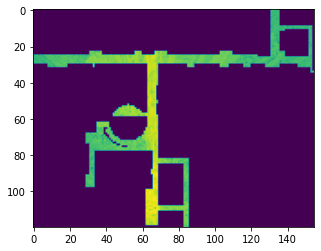

In [29]:
plt.imshow(hifi_data[0])

In [ ]:
train_set = torch.Tensor(train_set)
train_target = torch.Tensor(train_target)
valid_set = torch.Tensor(valid_set)
valid_target = torch.Tensor(valid_target)

print(train_set[0])
print(train_set.shape)
print(train_target.shape)
print(valid_set.shape)
print(valid_target.shape)

In [31]:
class DataSetImgs(torch.utils.data.Dataset):
    def __init__(self, low_fi, hi_fi, transform=None):
        self.low_fi=low_fi
        self.hi_fi=hi_fi
    def __len__(self):
        return len(self.low_fi)
    def __getitem__(self, idx):
        return (self.low_fi[idx].unsqueeze(0),self.hi_fi[idx].unsqueeze(0))

In [32]:
training_data_set=DataSetImgs(train_set,train_target)
val_data_set=DataSetImgs(valid_set,valid_target)
train_loader = torch.utils.data.DataLoader(training_data_set, batch_size=1)
valid_loader = torch.utils.data.DataLoader(val_data_set, batch_size=1)

In [33]:
# CNN architecture
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(14 * 19 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

        
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 14 * 19 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 14, 19))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        #print(x.shape)
        x = self.unflatten(x)
        #print(x.shape)
        x = self.decoder_conv(x)
        #print(x.shape)
        x = torch.sigmoid(x)
        #exit(0)
        return x

In [34]:
def lr_predict(w, b, x):
    # y_hat = sigmoid (wt x + b)
    
    # w is (D, )
    # x is (N, D), N vectors not just one

    return  sigmoid(x @ w + b)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [35]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.01

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cpu


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=8512, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 14, 19))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [36]:
print(decoder)
print(train_set[0].unsqueeze(0).shape)
out=encoder(train_set[0].unsqueeze(0).unsqueeze(0))
fin=decoder(out)

Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=8512, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 14, 19))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)
torch.Size([1, 120, 155])


In [37]:
### Training function
def train_epoch_den(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    accuracy = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for low_fi,hi_fi in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        low_fi = low_fi.to(device)
        hi_fi= hi_fi.to(device) 
        # Encode data
        encoded_data = encoder(low_fi)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data[:,:,:120,:155], hi_fi)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        train_loss.append(loss.detach().cpu().numpy())
        #return 0
    return np.mean(train_loss)

In [38]:
### Testing function
def test_epoch_den(encoder, decoder, device, dataloader, loss_fn,noise_factor=0.3):
    return 0
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    valid_loss = []
    accuracy = []
    with torch.no_grad(): # No need to track the gradients
        for low_fi,hi_fi in dataloader:
            encoded_data = encoder(low_fi)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Evaluate loss
            loss = loss_fn(decoded_data[:,:,:120,:155], hi_fi)
            # Evaluate global loss
            valid_loss.append(loss.detach().cpu().numpy())
            #accuracy.append(get_accuracy(decoded_data[:,:,:120,:155], hi_fi))

    return np.mean(valid_loss)

In [39]:

def get_accuracy(prediction, target):
    # print("OUr guess")
    # plt.imshow(prediction.squeeze().detach().numpy())
    # plt.show()
    # print("actual result")
    # plt.imshow(target.squeeze().detach().numpy())
    # plt.show()
    acc = accuracy(prediction,target)
    return acc

Our guess


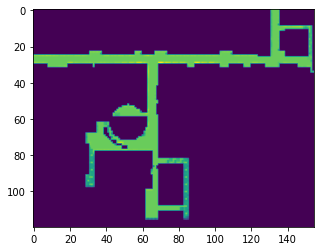

low_fi result


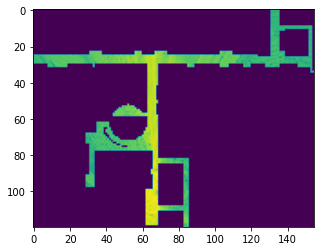

actual result


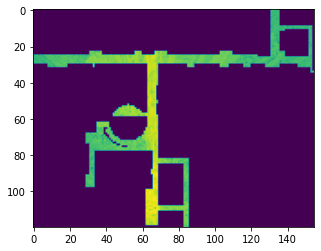

Our guess


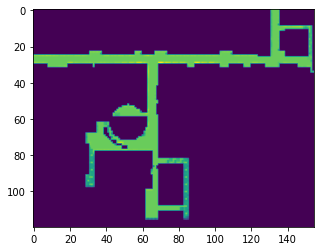

low_fi result


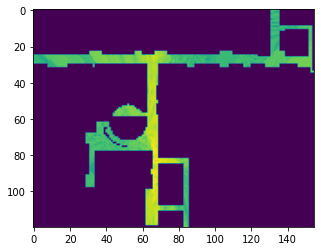

actual result


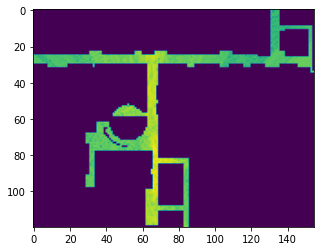

Our guess


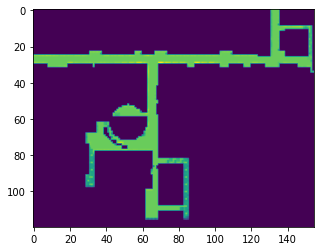

low_fi result


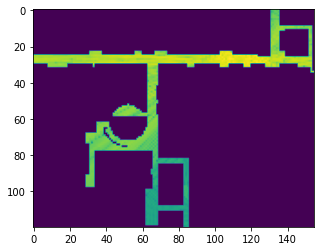

actual result


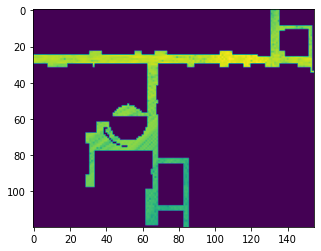

Our guess


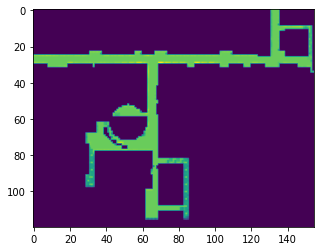

low_fi result


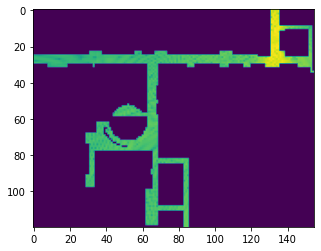

actual result


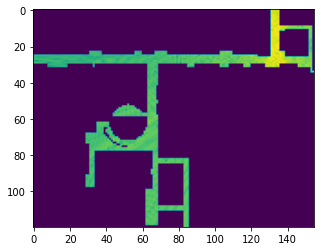

Our guess


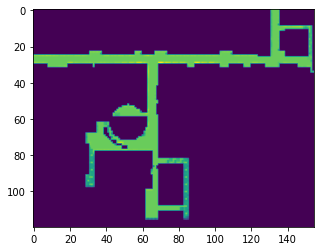

low_fi result


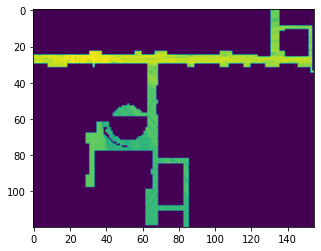

actual result


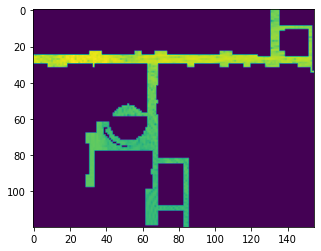

Our guess


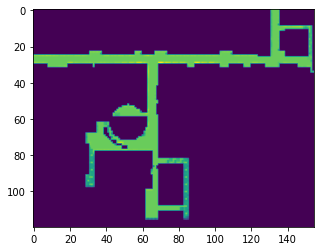

low_fi result


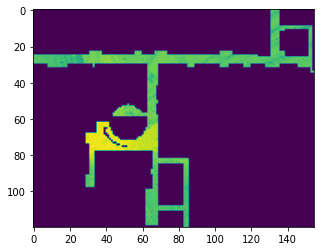

actual result


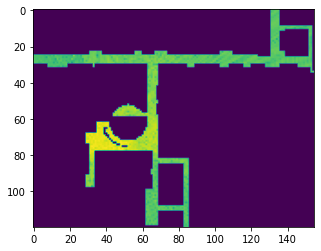

Our guess


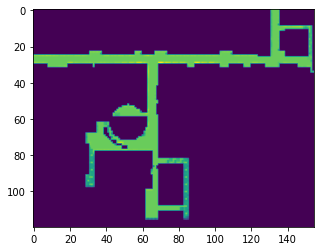

low_fi result


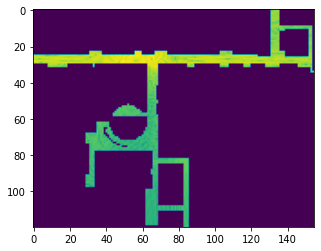

actual result


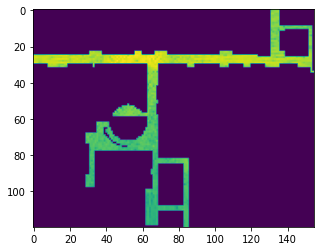

Our guess


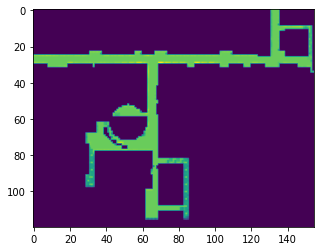

low_fi result


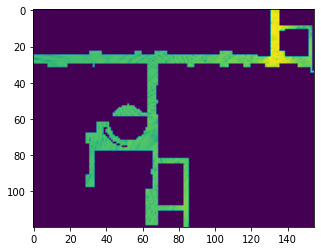

actual result


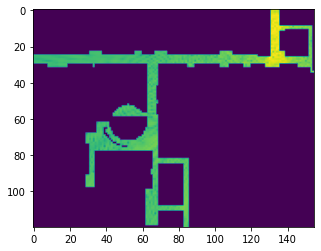

Our guess


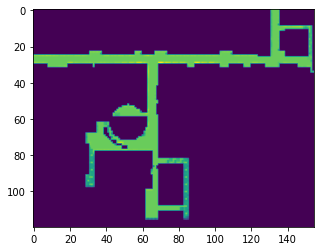

low_fi result


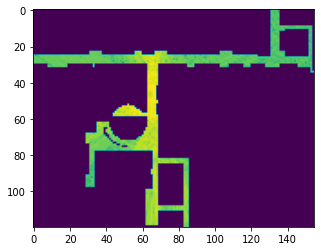

actual result


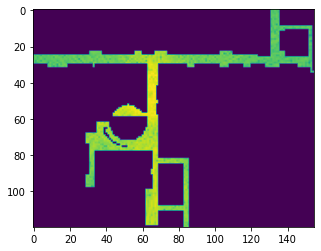

Our guess


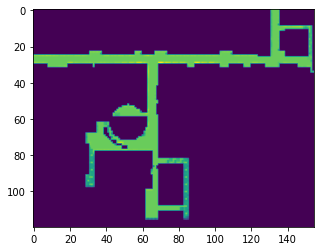

low_fi result


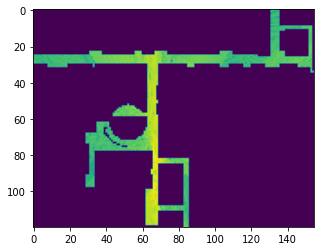

actual result


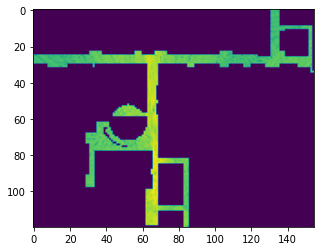

In [45]:
i=0
for test_low_fi,test_hi_fi in train_loader:
  if ((test_low_fi==test_hi_fi).all()):
    print("Low fidelity and high fidelity match up")
  encoded_data = encoder(test_low_fi)
  # Decode data
  decoded_data = decoder(encoded_data)
  print("Our guess")
  plt.imshow(decoded_data[:,:,:120,:155].squeeze().detach().numpy())
  plt.show()
  print("low_fi result")
  plt.imshow(test_low_fi.squeeze().detach().numpy())
  plt.show()
  print("actual result")
  plt.imshow(test_hi_fi.squeeze().detach().numpy())
  plt.show()
  i+=1
  if i==10:
    break

OUr guess


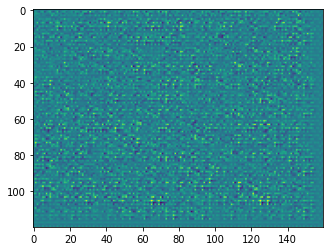

tensor([[[[0.4317, 0.4350, 0.4481,  ..., 0.4305, 0.4250, 0.4252],
          [0.4236, 0.5340, 0.4208,  ..., 0.4994, 0.4184, 0.4552],
          [0.4563, 0.5589, 0.5365,  ..., 0.4417, 0.4461, 0.4721],
          ...,
          [0.4842, 0.4854, 0.4581,  ..., 0.4758, 0.4300, 0.4425],
          [0.4055, 0.4247, 0.4431,  ..., 0.4341, 0.4554, 0.4489],
          [0.4188, 0.5184, 0.4151,  ..., 0.4809, 0.4320, 0.4665]]]],
       grad_fn=<SigmoidBackward0>)
actual result
tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]])


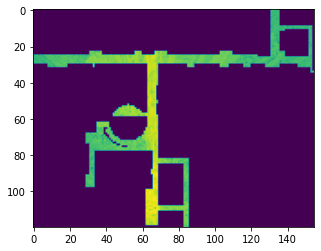

In [41]:
for test_low_fi,test_hi_fi in train_loader:
  encoded_data = encoder(test_low_fi)
  # Decode data
  decoded_data = decoder(encoded_data)
  print("OUr guess")
  plt.imshow(decoded_data.squeeze().detach().numpy())
  plt.show()
  print(decoded_data)
  print("actual result")
  plt.imshow(test_hi_fi.squeeze().detach().numpy())
  print(test_hi_fi)
  plt.show()
  break

EPOCH 1/30
loss 0.8850735
EPOCH 2/30
loss 0.88501585
EPOCH 3/30
loss 0.88499886
EPOCH 4/30
loss 0.8850083
EPOCH 5/30
loss 0.88497084
EPOCH 6/30
loss 0.8849663
EPOCH 7/30
loss 0.88495845
EPOCH 8/30
loss 0.88496745
EPOCH 9/30
loss 0.8849868
EPOCH 10/30
loss 0.88494724
EPOCH 11/30
loss 0.8849261
EPOCH 12/30
loss 0.88493484
EPOCH 13/30
loss 0.8849337
EPOCH 14/30
loss 0.8849729
EPOCH 15/30
loss 0.88490003
EPOCH 16/30
loss 0.8849365
EPOCH 17/30
loss 0.88492185
EPOCH 18/30
loss 0.88491505
EPOCH 19/30
loss 0.8849252
EPOCH 20/30
loss 0.8849425
EPOCH 21/30
loss 0.8848877
EPOCH 22/30
loss 0.8849219
EPOCH 23/30
loss 0.8849087
EPOCH 24/30
loss 0.88491666
EPOCH 25/30
loss 0.88486177
EPOCH 26/30
loss 0.88492495
EPOCH 27/30
loss 0.88489455
EPOCH 28/30
loss 0.88486266
EPOCH 29/30
loss 0.8848887
EPOCH 30/30
loss 0.8848602


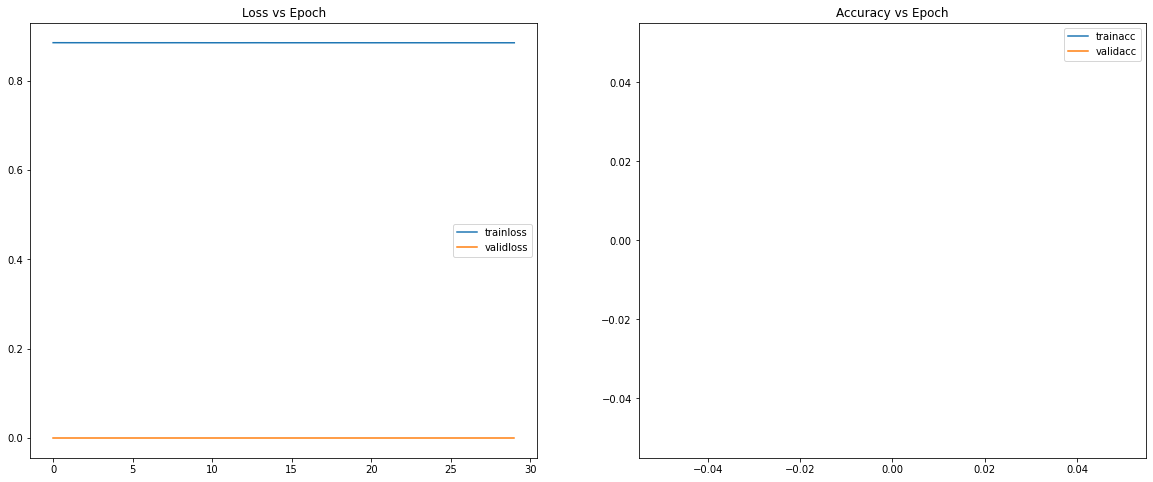

In [44]:
### Training cycle
noise_factor = 0.3
num_epochs = 30
history_da={'train_loss':[],'val_loss':[]}
train_loss = []
train_acc, valid_acc = [], []
val_loss = []
for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training (use the training function)
    tloss = train_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_loader, 
        loss_fn=loss_fn, 
        optimizer=optim,
        )
    train_loss.append(tloss)
    print("loss", tloss)
    #train_acc.append(taccuracy)
    ### Validation  (use the testing function)
    valid_loss = test_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=valid_loader, 
        loss_fn=loss_fn,noise_factor=noise_factor)
    val_loss.append(valid_loss)
    #valid_acc.append(vaccuracy)
    # Print Validationloss
    history_da['train_loss'].append(train_loss)
    history_da['val_loss'].append(val_loss)
    

    #print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    #plot_ae_outputs_den(encoder,decoder,noise_factor=noise_factor)

plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
plt.title("Loss vs Epoch") 
plt.plot(range(0, len(train_loss)),train_loss,label='trainloss') 
plt.plot(range(0, len(val_loss)),val_loss,label='validloss') 

plt.legend(loc = 'best')
plt.subplot(1, 2, 2)
plt.title("Accuracy vs Epoch") 
plt.plot(range(0,len(train_acc)),train_acc,label='trainacc') 
plt.plot(range(0,len(valid_acc)),valid_acc,label='validacc')
plt.legend(loc = 'best') 
plt.show()


In [56]:
torch.save(encoder.state_dict(), "/content/drive/MyDrive/ECE496 Capstone Project/Saved Model/encoder_weights")

In [55]:
torch.save(decoder.state_dict(), "/content/drive/MyDrive/ECE496 Capstone Project/Saved Model/decoder_weights")